# Viewing model checkpoints, viewing predictions, plotting losses evolutions and testing the model
This notebook is provided as is, to show a few examples of how to interact with the codebase.
### Needed imports

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import h5py
import PIL
import sys  
import os
import torch
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
#from data.convert_distance_to_depth import * 
from set_method import my_method, Method


module_path = os.path.abspath(os.path.dirname(os.getcwd()))+"/../" # Only works if cwd correctly gets the model folder.

test_path = os.path.abspath(os.path.dirname(os.getcwd()))

if test_path not in sys.path:
    sys.path.append(test_path)

if module_path not in sys.path:
    sys.path.append(module_path)

from data.convert_distance_to_depth import *
from loaddata import *

from data.plot_scripts import * 

from set_method import *

from test import edge_detection


In [3]:
#test_dataframe = pd.read_csv("../../data/downloads/image_file_test.csv")

# Validation from the cluster:
# Depth,Segmentation,ToneMapped
# ai_001_001/images/scene_cam_00_geometry_hdf5/frame.0006.depth_meters.hdf5,ai_001_001/images/scene_cam_00_geometry_hdf5/frame.0006.semantic.hdf5,ai_001_001/images/scene_cam_00_final_preview/frame.0006.tonemap.jpg
os.environ["THREED_VISION_ABSOLUTE_DOWNLOAD_PATH"] = "/home/user/ethz/semester4/3dVision/3DVision--Infusing-Monocular-Depth-Semantic/data/downloads/"
# os.environ["THREED_VISION_ABSOLUTE_DOWNLOAD_PATH"] = "/home/user/Nextcloud/Documents/ETHZ/semester4/3dVision/3DVision--Infusing-Monocular-Depth-Semantic/data/downloads/"
# os.environ["THREED_VISION_ABSOLUTE_DOWNLOAD_PATH"] = "/Users/alicemazzoleni/Documents/3dVision/3DVision--Infusing-Monocular-Depth-Semantic/data/downloads/"
download_path = os.getenv("THREED_VISION_ABSOLUTE_DOWNLOAD_PATH")


mean,std = [0.53277088, 0.49348648, 0.45927282],[0.238986 ,  0.23546355 ,0.24486044] 

if(torch.cuda.is_available()):
    device = "cuda:0"
else:
    device="cpu"

### Specify all the file paths

In [4]:
#choose validation images dataset path 
#validation_image_path = ["ai_001_001/images/scene_cam_00_geometry_hdf5/frame.0006.depth_meters.hdf5","ai_001_001/images/scene_cam_00_geometry_hdf5/frame.0006.semantic.hdf5","ai_001_001/images/scene_cam_00_final_preview/frame.0006.tonemap.jpg"] 
#validation_image_path_csv = "../outputs/results/"+ "valid_image.csv"
validation_image_path_csv = "Final_Test_Data.csv"
validation_depth_tensors = "../outputs/results/"+ "validation-.05-10-2023-14-59-41-depth.pt"

validation_progress = download_path + "../outputs/results/"+"validation-.05-15-2023-20-09-01-Method.SEGMENTATIONMASKGRAYSCALE-results.csv"

#choose test images dataset 

#choose training losses
train_progress_file = "checkpointapple-.05-16-2023-23-16-38-Method.SEGMENTATIONMASKBOUNDARIES-final.pth.tar"
training_progress_data = download_path + "../outputs/results/"+train_progress_file
# Choose the model to load here please:
model_checkpoint_file = "checkpointapple-.06-02-2023-20-54-43-Method.SEGMENTATIONMASKONEHOT-only_relevant_classes.csv.final.pth.tar"
model_checkpoint_path = download_path+"../outputs/checkpoints/"+model_checkpoint_file

#set method
#NOSEGMENTATIONCUES, SEGMENTATIONMASKGRAYSCALE, SEGMENTATIONMASKBOUNDARIES, SEGMENTATIONMASKONEHOT,JOINTLEARNING
my_method = Method.SEGMENTATIONMASKONEHOT

In [5]:
def test_sample(model, test_loader): 
    model.eval()
    depth_results = []
    if(torch.cuda.is_available()):
        model.to("cuda:0")
    else:model.to("cpu")
    for i, sample_batched in enumerate(test_loader):
        torch.cuda.empty_cache()
        
        image, depth = sample_batched['image'], sample_batched['depth']
        if(torch.cuda.is_available()):
            depth = depth.cuda(non_blocking=True) #
            image = image.cuda()
        image = torch.autograd.Variable(image, requires_grad=False)
        depth = torch.autograd.Variable(depth, requires_grad=False)
        output = model(image)
        output = torch.nn.functional.interpolate(output, size=[depth.size(2),depth.size(3)], mode='bilinear')
        #display_tensor_data(output[0,:].detach())
        #display_tensor_data(depth[0,:])
        #plt.imshow(output[0,:].permute(1, 2, 0).detach().numpy())
        #plt.show()
        depth_results.append([output.detach(),depth.detach() ,image.detach()])
        torch.cuda.empty_cache()
        
    return depth_results

In [6]:

def test_sample_joint(model, convert_probabilities_to_labels, test_loader): 
    model.eval()
    depth_results = []
    if(torch.cuda.is_available()):
        model.to("cuda:0")
    else:model.to("cpu")
    for i, sample_batched in enumerate(test_loader):
        torch.cuda.empty_cache()
        
        image, depth, segmentation_mask = sample_batched['image'], sample_batched['depth'], sample_batched['segmentation']
        if(torch.cuda.is_available()):
            depth = depth.cuda(non_blocking=True) #
            image = image.cuda()
        image = torch.autograd.Variable(image, requires_grad=False)
        depth = torch.autograd.Variable(depth, requires_grad=False)
        segmentation_mask = torch.autograd.Variable(segmentation_mask, requires_grad=False)
        depth_output, segmentation_output = model(image)
        output_depth = torch.nn.functional.interpolate(depth_output, size=[depth.size(2),depth.size(3)], mode='bilinear')
        segmentation_output = convert_probabilities_to_labels.convert_probability_to_labels(segmentation_output)
        segmentation_mask = convert_probabilities_to_labels.convert_probability_to_labels(segmentation_mask)
        #output_segmentation = torch.nn.functional.interpolate(segmentation_output, size=[segmentation_mask.size(2), segmentation_mask.size(3)], mode="nearest")
        #display_tensor_data(output[0,:].detach())
        #display_tensor_data(depth[0,:])
        #plt.imshow(output[0,:].permute(1, 2, 0).detach().numpy())
        #plt.show()
        depth_results.append([output_depth.detach(),depth.detach(), segmentation_output.detach(), segmentation_mask.detach(), image.detach()])
        torch.cuda.empty_cache()
        
    return depth_results

### Loading the Model For testing

In [8]:
selected_segmentation_classes = "only_relevant_classes.csv"#"all_classes.csv"
data_path = os.path.abspath(os.path.dirname("./../../data/"))
csv_file_reader = open(data_path+"/segmentation_classes/" + selected_segmentation_classes)
num_segmentation_classes = sum(1 for line in csv_file_reader) - 1


In [9]:
from train import define_model

# Model loading for prediction on test sample:

model = define_model(is_resnet = True, is_densenet=False, is_senet=False, num_segmentation_classes=num_segmentation_classes,pretrained = False)

state_dict = torch.load(model_checkpoint_path, map_location=torch.device(device))["state_dict"]

model.load_state_dict(state_dict=state_dict)
model.to(device=device)
model.eval();

### Loading the Data For testing

In [10]:
# Load the data for testing

convert_probabilities_to_labels = ConvertProbabilitiesToLabels(selected_segmentation_classes)

torch.cuda.empty_cache()
test_loader = getTestingData(1, validation_image_path_csv, selected_segmentation_classes)
#depth_results = test_sample_joint(model, convert_probabilities_to_labels, test_loader)
depth_results = test_sample(model, test_loader)

#tensors_name = ["Baseline", "Grayscale", "Edge", "OneHot", "JOINT"]
tensor_name = "tensors_"+"Grayscale"
torch.save(depth_results, os.environ["THREED_VISION_ABSOLUTE_DOWNLOAD_PATH"]+"../outputs/tensors/"+tensor_name)

My Method in dataloader is:  Method.SEGMENTATIONMASKONEHOT


/home/user/ethz/semester4/3dVision/.3d-env/lib/python3.11/site-packages/torch/nn/functional.py:3737: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


### Test the Edge Detection Threshold

5
tensor(False)
tensor(True)
tensor(False)
tensor(True)


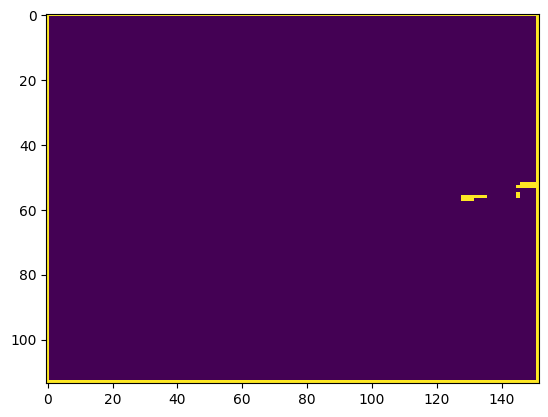

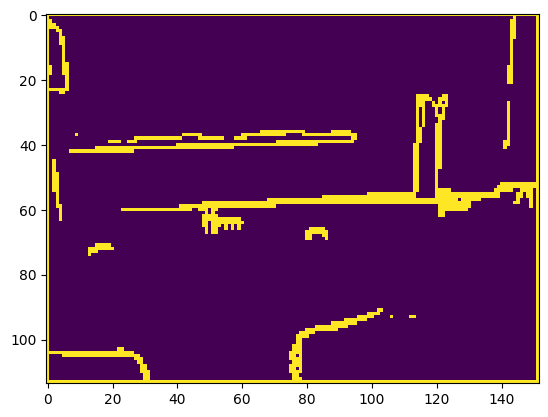

tensor(False)
tensor(True)
tensor(False)
tensor(True)


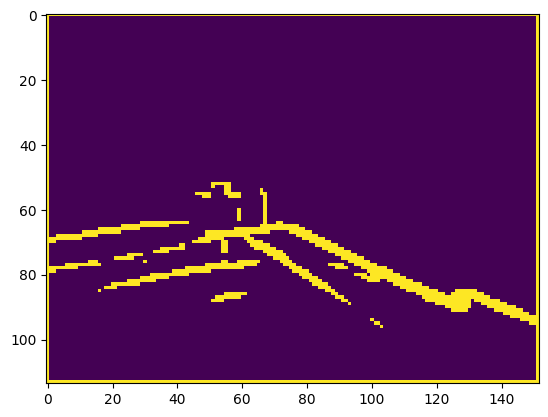

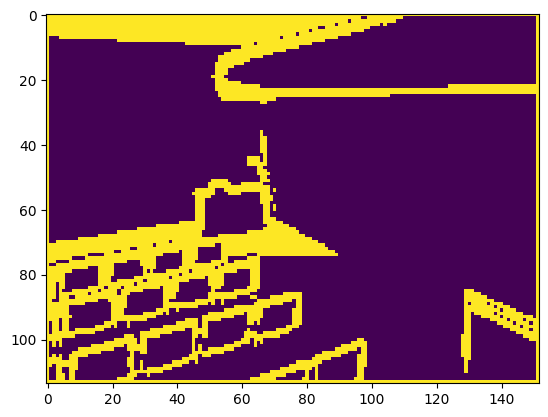

tensor(False)
tensor(True)
tensor(False)
tensor(True)


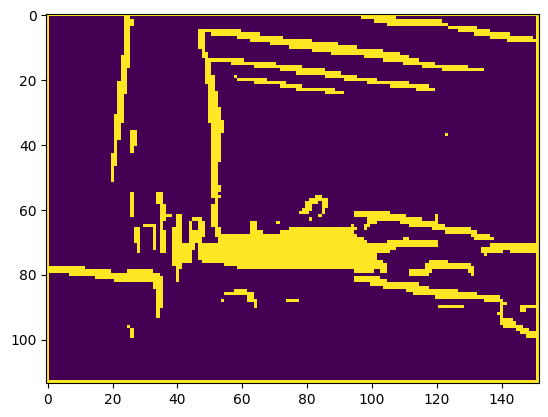

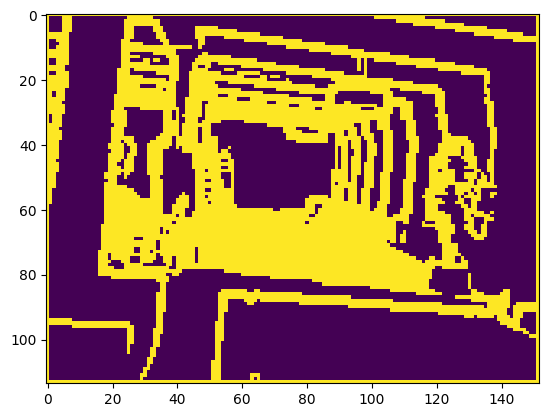

tensor(False)
tensor(True)
tensor(False)
tensor(True)


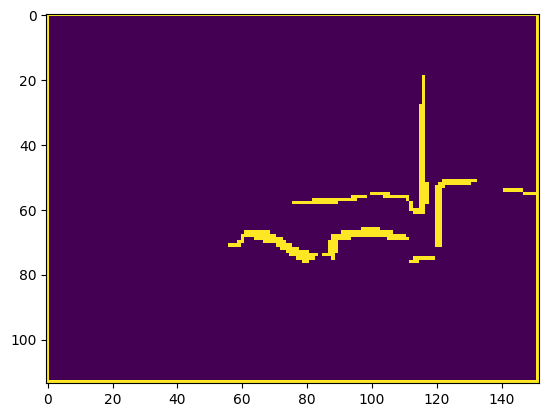

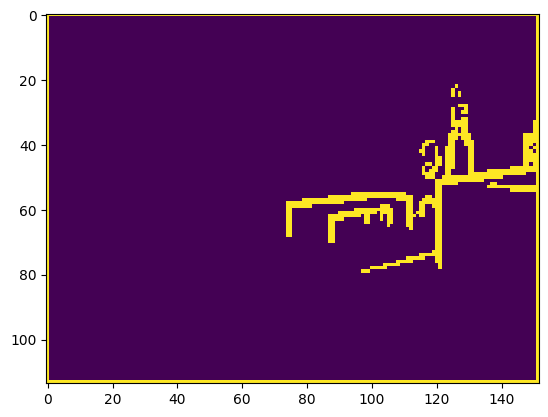

tensor(False)
tensor(True)
tensor(False)
tensor(True)


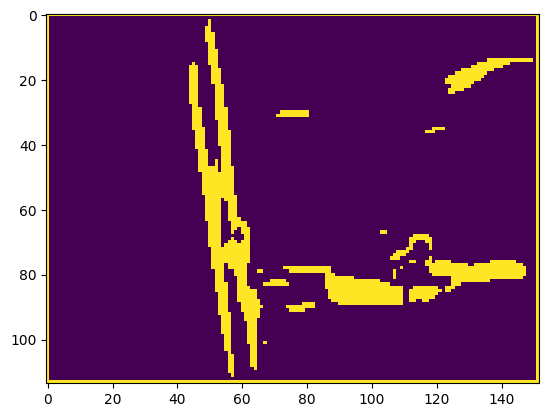

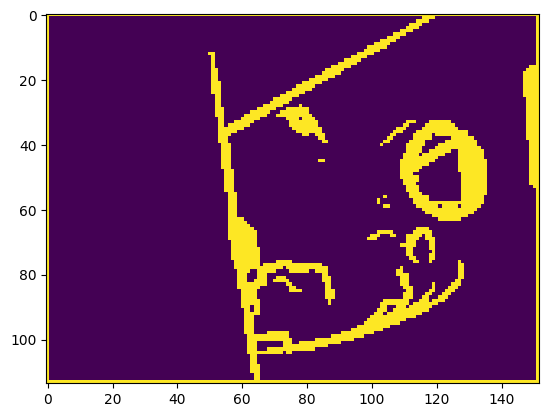

In [11]:

for tensor in depth_results: 
    depth_edge = edge_detection(tensor[0])
    depth_edge = depth_edge > 1.5
    depth_edge_GT = edge_detection(tensor[1])
    depth_edge_GT = depth_edge_GT > 1.5
    plt.imshow(depth_edge.permute(1,2,0))
    plt.show()
    plt.imshow(depth_edge_GT.permute(1,2,0))
    plt.show()

In [11]:
def plot_results(tensors, plot_name=None):
    
    y_labels = {"RGB": "RGB", "GT": "Ground Truth", "Baseline": "No Segmentation Cues", "Grayscale": "Grayscale", "Edge": "Boundary Edge Mask", "OneHotno_chairs": "One Hot Encoded Labels"}
    
    num_images = len(tensors["RGB"])
    fig, axs = plt.subplots(nrows=6, ncols=num_images, figsize=(12, 16)) #, constrained_layout=True)
    fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.13, hspace=0.0)

    for key_index, key in enumerate(["RGB", "GT", "Baseline", "Grayscale", "Edge", "OneHotno_chairs"]):
        print("num_images: ", len(tensors[key]))
        for i, tensor in enumerate(tensors[key]):
            if key == "RGB":
                tensor = denormalize(tensor)
            pcm = axs[key_index,i].imshow(tensor.permute(1, 2, 0))
            axs[key_index,i].set_xticks([])
            axs[key_index,i].set_yticks([])
            if key != "RGB":
                fig.colorbar(pcm, ax=axs[key_index,i], fraction=0.035, pad=0.02) #0.046, 0.04
            
            
        axs[key_index, 0].set_ylabel(y_labels[key])
        
       
    #fig.tight_layout() 
    
    plt.show()
    
    if plot_name is not None:
        fig.savefig(os.environ['THREED_VISION_ABSOLUTE_DOWNLOAD_PATH']+"../plots/validation_error_plots/"+plot_name+".png", bbox_inches='tight')

In [12]:
def display_tensor_data_many(tensors_dict, remap, titles, colorbar, figsize=(15, 15), fontsize=12, plot_name=None):
    
    n_columns = len(titles)
    n_rows = len(tensors_dict["RGB"])
    print(n_rows)
    fig, axes = plt.subplots(n_rows, n_columns, figsize=figsize)
    #fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.13, hspace=0.0)
    
    for key_index, key in enumerate(tensors_dict.keys()):
        for tensor_index, tensor in enumerate(tensors_dict[key]): 
            if remap[key] is not None:
                tensor = remap[key](tensor)     
            pcm = axes[tensor_index,key_index].imshow(tensor.permute(1, 2, 0))
            axes[tensor_index,key_index].set_xticks([])
            axes[tensor_index,key_index].set_yticks([])
            
            if colorbar[key] == True:
                fig.colorbar(pcm, ax=axes[tensor_index,key_index], fraction=0.035, pad=0.02) #0.046, 0.04
            
            
        axes[0, key_index].set_title(titles[key], fontsize=fontsize)
        
    fig.tight_layout()
    plt.show()

    if plot_name is not None:
        fig.savefig(os.environ['THREED_VISION_ABSOLUTE_DOWNLOAD_PATH']+"../plots/validation_error_plots/"+plot_name+".png", bbox_inches='tight')

In [16]:
tensors_name = ["Baseline", "Grayscale", "Edge", "OneHotno_chairs"]

image_size = [228, 304]
interpolate = interpolate = lambda input : torch.nn.functional.interpolate(torch.unsqueeze(input,0), size=image_size, mode='bilinear')[0, : ,:, :]
remap = {"RGB": denormalize, "GT": interpolate, "Baseline": interpolate, "Grayscale": interpolate, "Edge": interpolate, "OneHotno_chairs": interpolate}
titles = {"RGB": "RGB", "GT": "Ground Truth", "Baseline": "No Segmentation Cues", "Grayscale": "Grayscale", "Edge": "Boundary Edge Mask", "OneHotno_chairs": "One Hot Encoded Labels"}
colorbar = {"RGB": False, "GT": True, "Baseline": True, "Grayscale": True, "Edge": True, "OneHotno_chairs": True}

tensor_dictionary = {}
for name in tensors_name:
    depth_tensor = torch.load(os.environ["THREED_VISION_ABSOLUTE_DOWNLOAD_PATH"]+"../outputs/tensors/"+"tensors_"+name, map_location=torch.device('cpu'))
    predicted_depth_outputs = []
    if name == "Baseline":
        rgb_outputs = []
        GT_outputs = []
    for i, tensors in enumerate(depth_tensor[0:-1]):
        if name == "JOINT":
            outputs,depths,_,_,rgbs = tensors
        else: 
            outputs,depths,rgbs = tensors 
        outputs = outputs[0,:,:,:].cpu()
        predicted_depth_outputs.append(outputs); 
        if name == "Baseline": 
            rgb = rgbs[0,-3:,:,:].cpu()
            rgb_outputs.append(rgb)
            depth = depths[0,:,:,:].cpu()
            GT_outputs.append(depth)
    
    if name == "Baseline": 
        tensor_dictionary.update({"RGB": rgb_outputs})
        tensor_dictionary.update({"GT": GT_outputs}) 
        
    tensor_dictionary.update({name: predicted_depth_outputs})

4


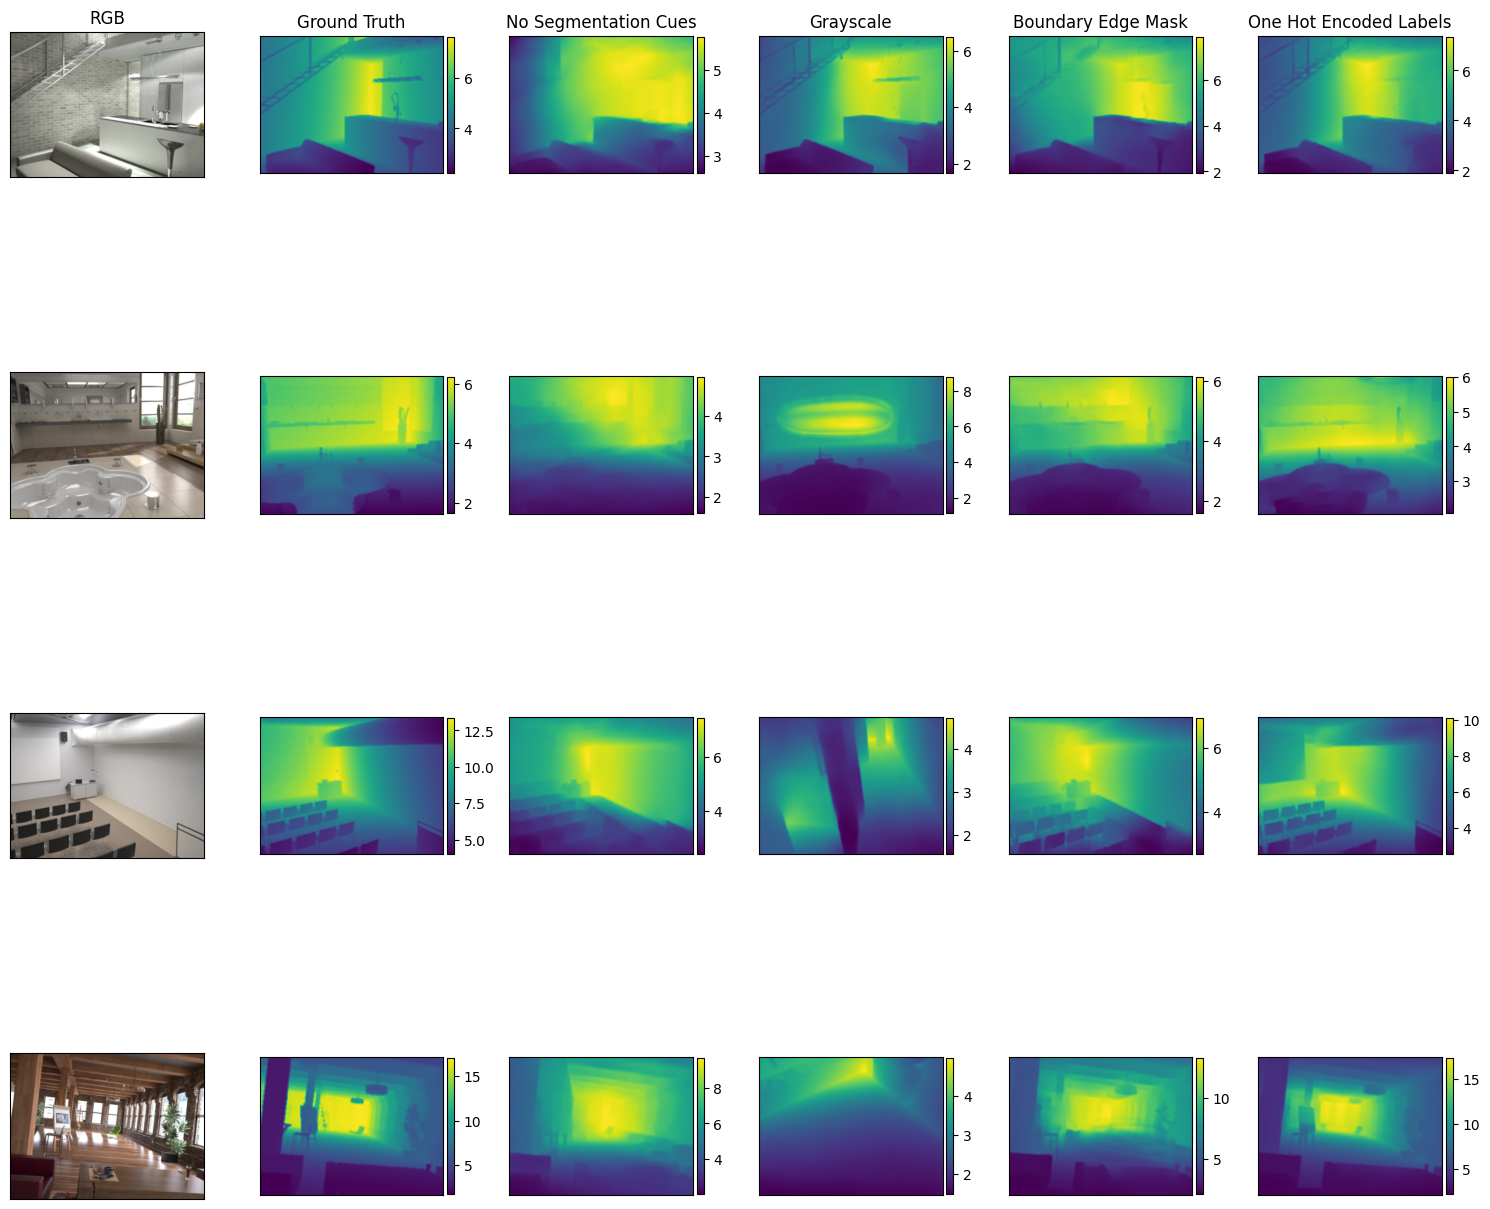

In [17]:
#plot_name = "final_report_plots"
plotname = None
#plot_results(tensor_dictionary, plot_name)
display_tensor_data_many(tensor_dictionary,remap, titles, colorbar, plot_name=plotname)

2


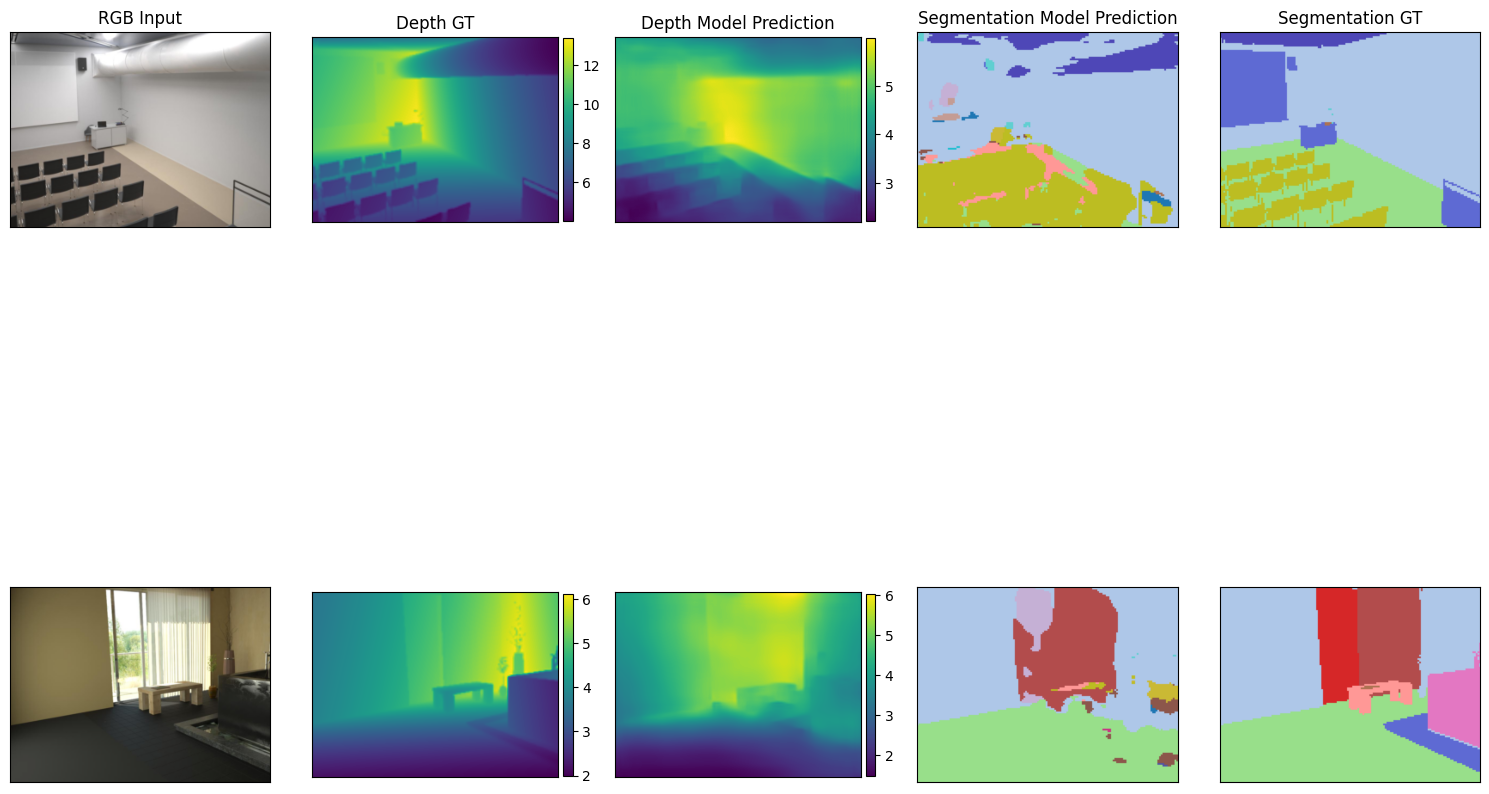

In [161]:
#plotname = "joint_learning_plots" 
#plotname = None
convert_semantic_labels_to_rgb = ConvertSemanticLabelsToRGB()
depth_tensor = torch.load(os.environ["THREED_VISION_ABSOLUTE_DOWNLOAD_PATH"]+"../outputs/tensors/"+"tensors_JOINT", map_location=torch.device('cpu'))

predicted_depth_outputs = [] 
rgb_outputs = [] 
GT_outputs = []
GT_segmentation_outputs = [] 
predicted_segmentation_outputs = [] 

tensor_dictionary = {} 

image_size = [228, 304]

interpolate = lambda input : torch.nn.functional.interpolate(torch.unsqueeze(input,0), size=image_size, mode='bilinear')[0, : ,:, :]

remap = {"RGB": denormalize, "GTDepth": interpolate, "PredDepth": interpolate, "GTSegmentationMask" : convert_semantic_labels_to_rgb, "PredSegmentationMask": convert_semantic_labels_to_rgb}
titles = {"RGB": "RGB Input", "GTDepth": "Depth GT", "PredDepth": "Depth Model Prediction", "GTSegmentationMask": "Segmentation GT", "PredSegmentationMask": "Segmentation Model Prediction"}
colorbar = {"RGB": False, "GTDepth": True, "PredDepth": True, "GTSegmentationMask" : False, "PredSegmentationMask": False}

for i, tensors in enumerate(depth_tensor[2:5:2]):
    
    outputs,depths,segmentation_pred, segmentation_mask, rgbs = tensors
    outputs = outputs[0,:,:,:].cpu()
    predicted_depth_outputs.append(outputs); 
    rgb = rgbs[0,-3:,:,:].cpu()
    rgb_outputs.append(rgb)
    depth = depths[0,:,:,:].cpu()
    GT_outputs.append(depth)
    predicted_segmentation_outputs.append(segmentation_pred[0,:,:].cpu())
    GT_segmentation_outputs.append(segmentation_mask[0, :, :].cpu())
    
tensor_dictionary.update({"RGB": rgb_outputs})
tensor_dictionary.update({"GTDepth": GT_outputs}) 
        
tensor_dictionary.update({"PredDepth": predicted_depth_outputs})
tensor_dictionary.update({"PredSegmentationMask": predicted_segmentation_outputs})
tensor_dictionary.update({"GTSegmentationMask": GT_segmentation_outputs})
 

display_tensor_data_many(tensor_dictionary,remap, titles, colorbar, plot_name=plotname)


torch.Size([1, 114, 152])
torch.Size([1, 114, 152])
torch.Size([3, 228, 304])


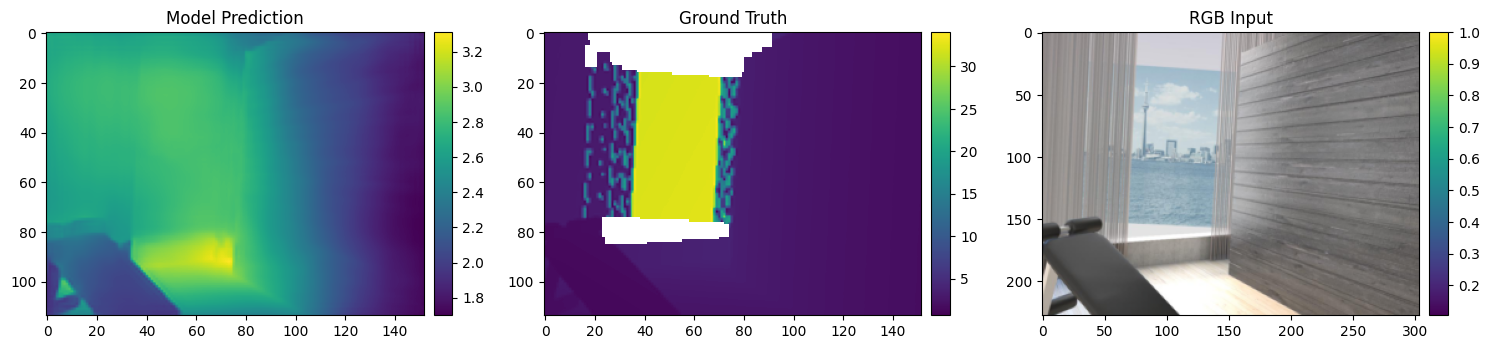

torch.Size([1, 114, 152])
torch.Size([1, 114, 152])
torch.Size([3, 228, 304])


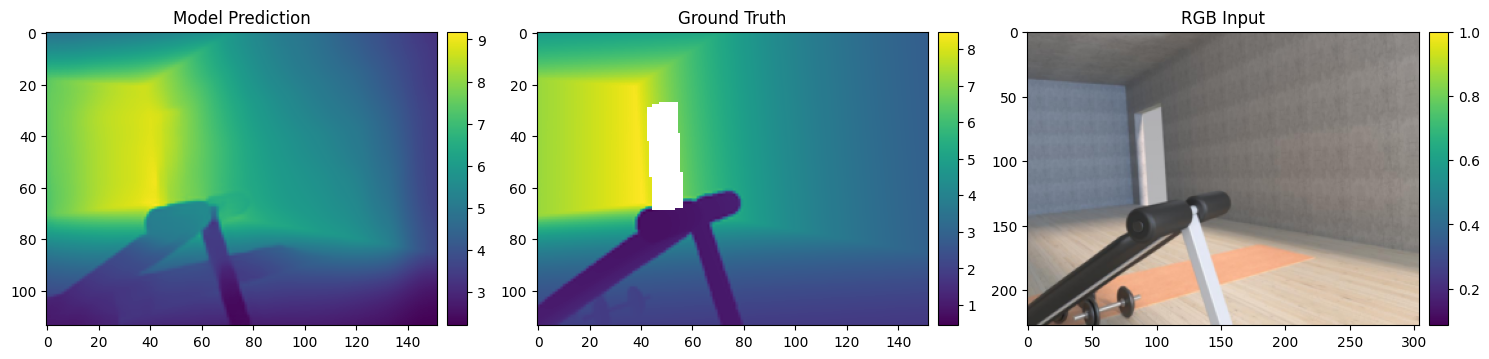

torch.Size([1, 114, 152])
torch.Size([1, 114, 152])
torch.Size([3, 228, 304])


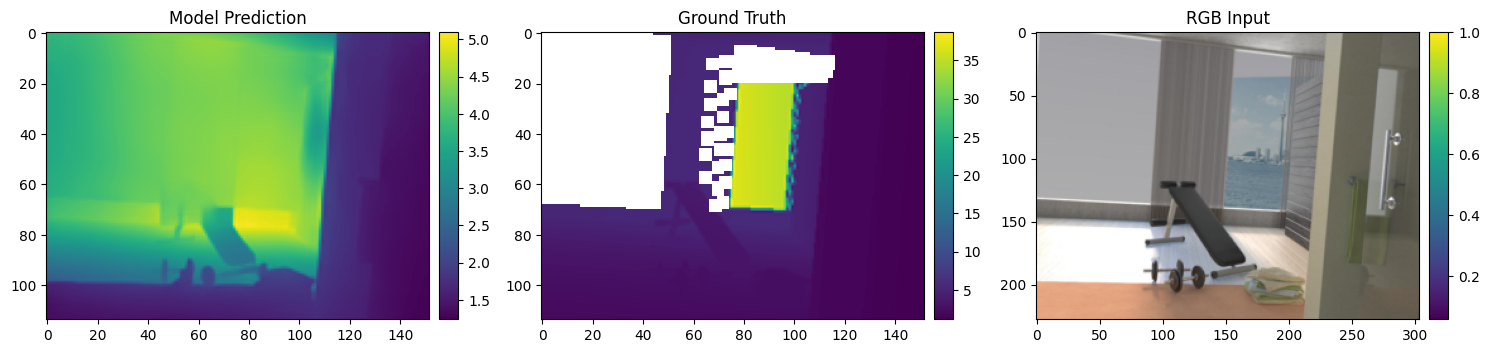

torch.Size([1, 114, 152])
torch.Size([1, 114, 152])
torch.Size([3, 228, 304])


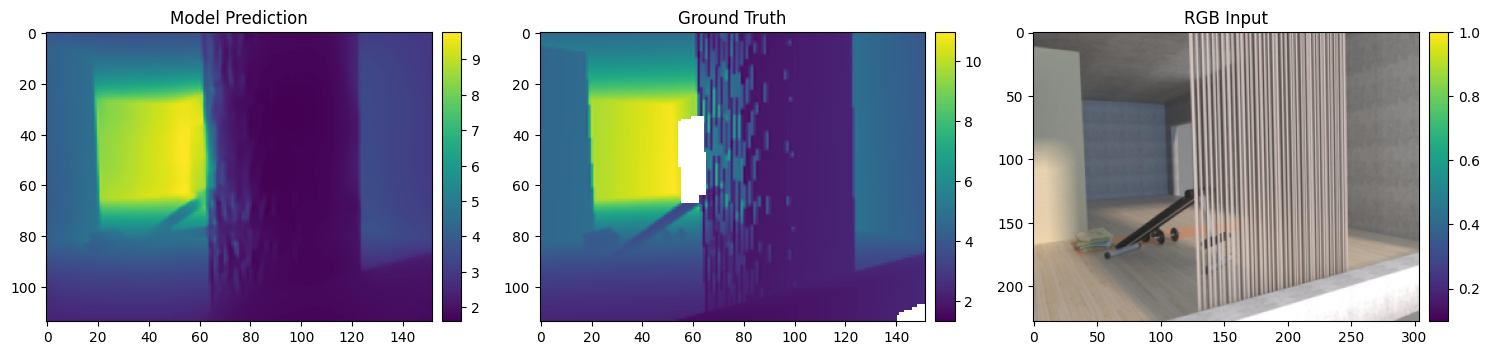

torch.Size([1, 114, 152])
torch.Size([1, 114, 152])
torch.Size([3, 228, 304])


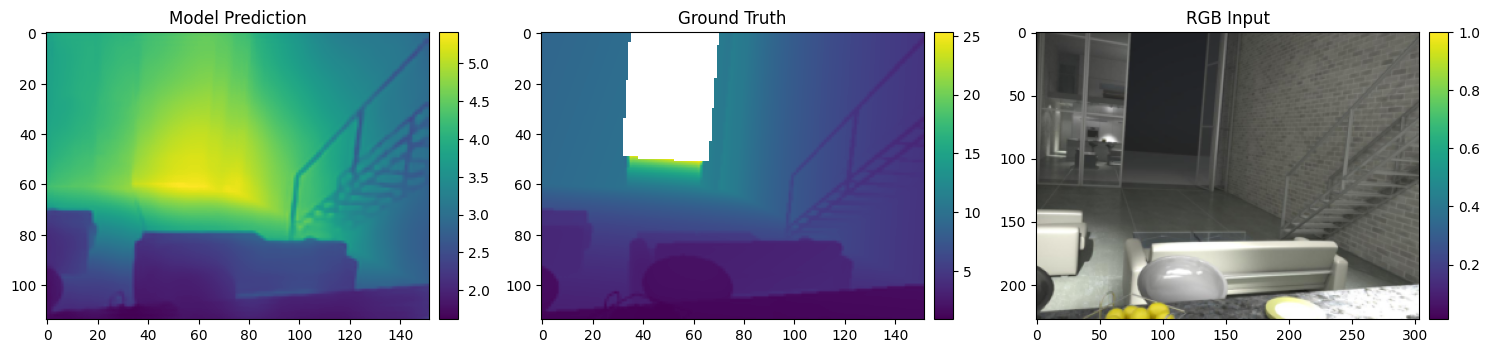

torch.Size([1, 114, 152])
torch.Size([1, 114, 152])
torch.Size([3, 228, 304])


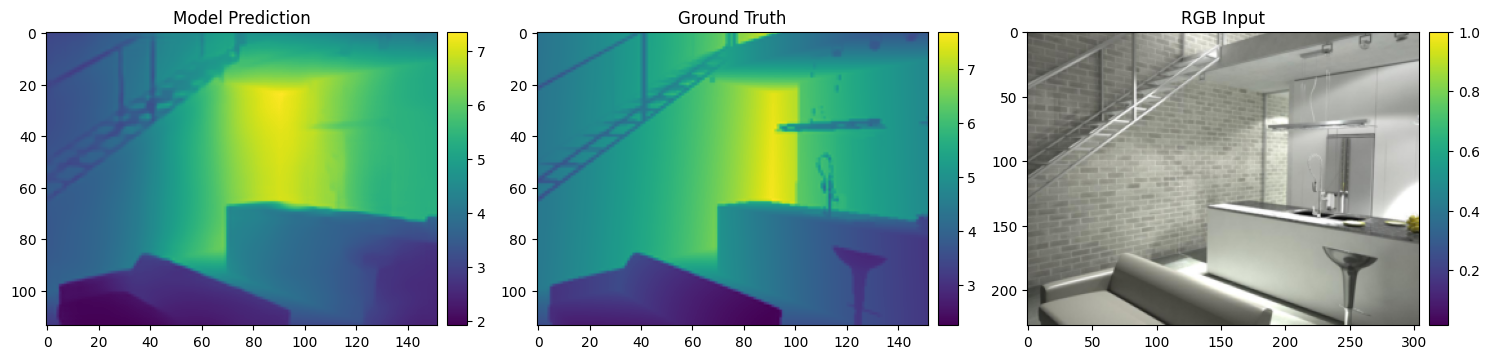

torch.Size([1, 114, 152])
torch.Size([1, 114, 152])
torch.Size([3, 228, 304])


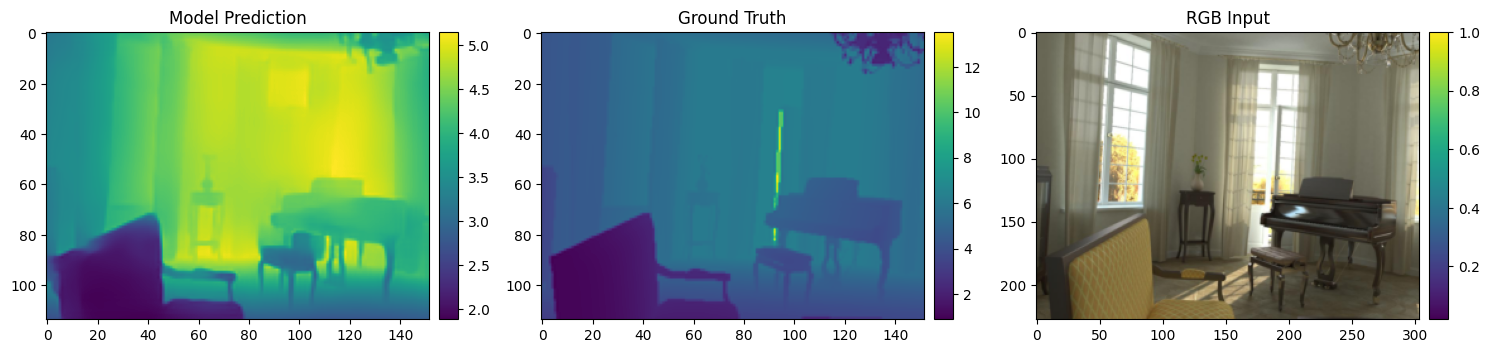

torch.Size([1, 114, 152])
torch.Size([1, 114, 152])
torch.Size([3, 228, 304])


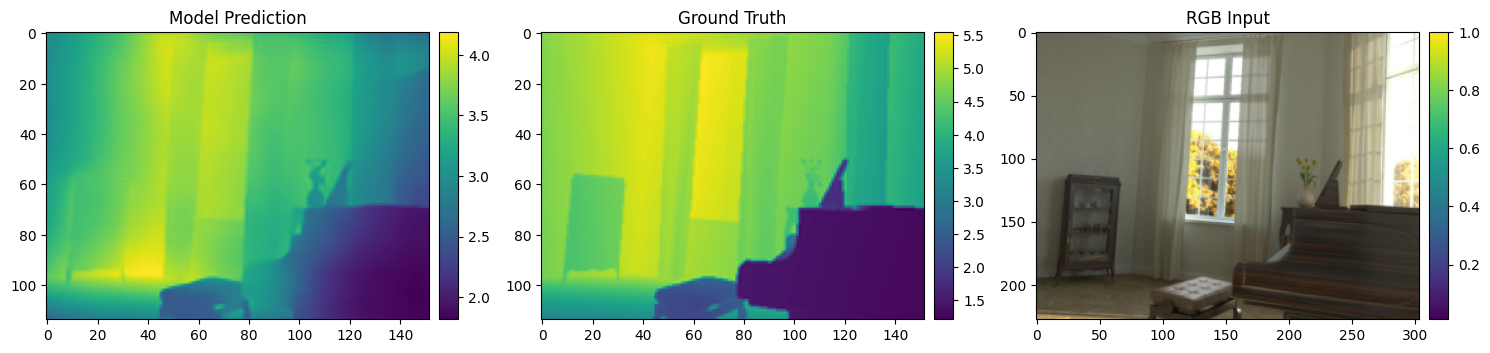

torch.Size([1, 114, 152])
torch.Size([1, 114, 152])
torch.Size([3, 228, 304])


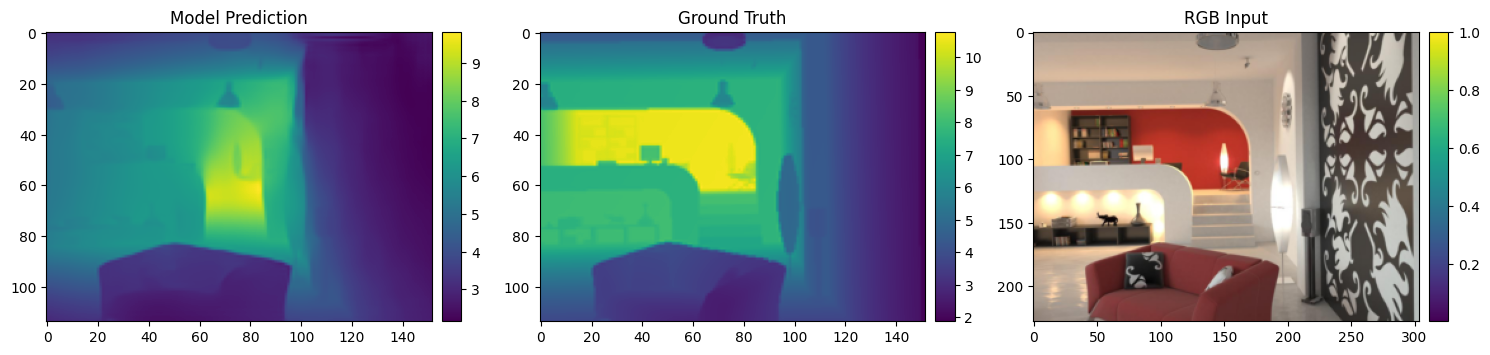

torch.Size([1, 114, 152])
torch.Size([1, 114, 152])
torch.Size([3, 228, 304])


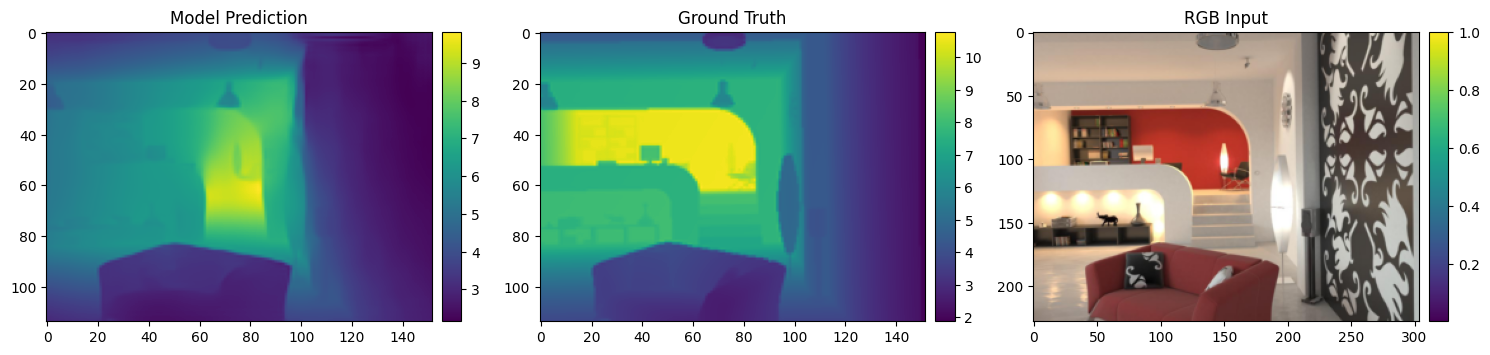

torch.Size([1, 114, 152])
torch.Size([1, 114, 152])
torch.Size([3, 228, 304])


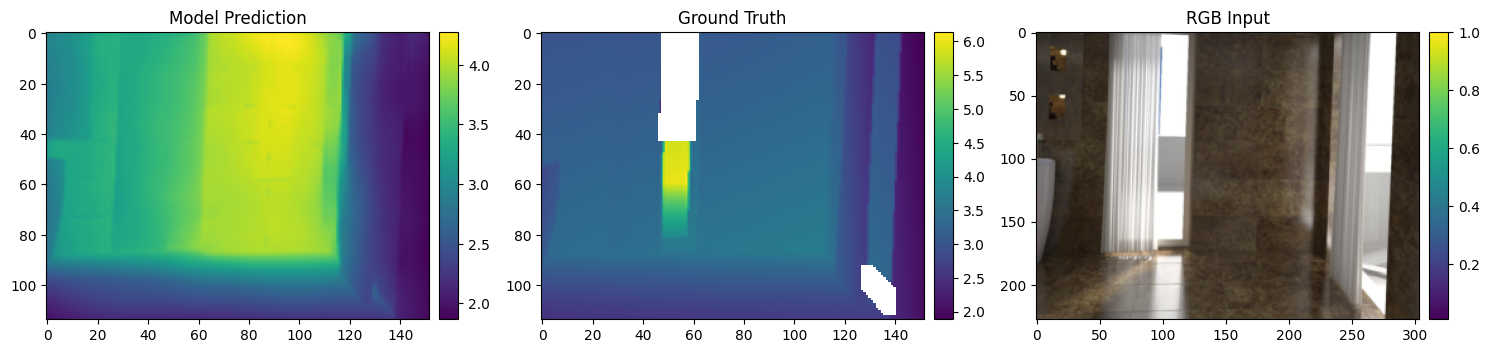

torch.Size([1, 114, 152])
torch.Size([1, 114, 152])
torch.Size([3, 228, 304])


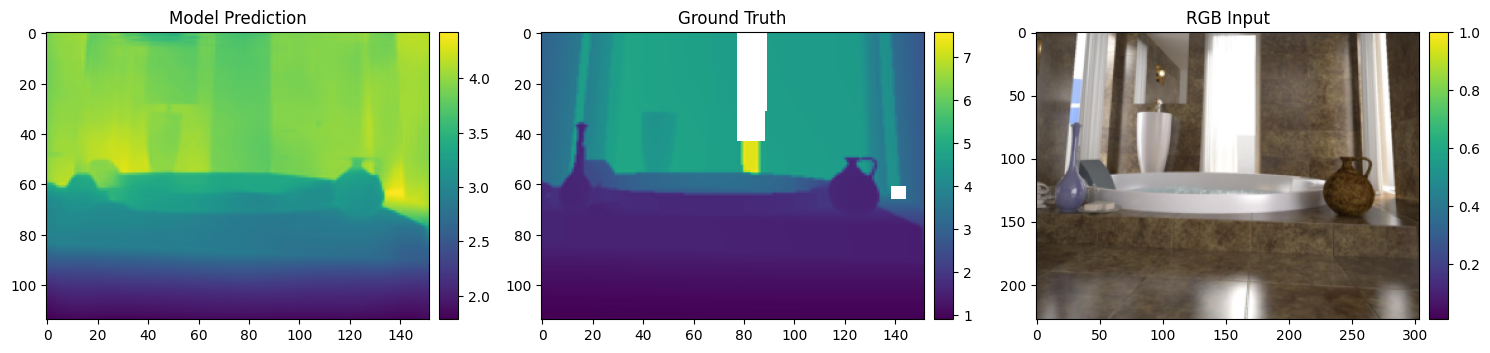

torch.Size([1, 114, 152])
torch.Size([1, 114, 152])
torch.Size([3, 228, 304])


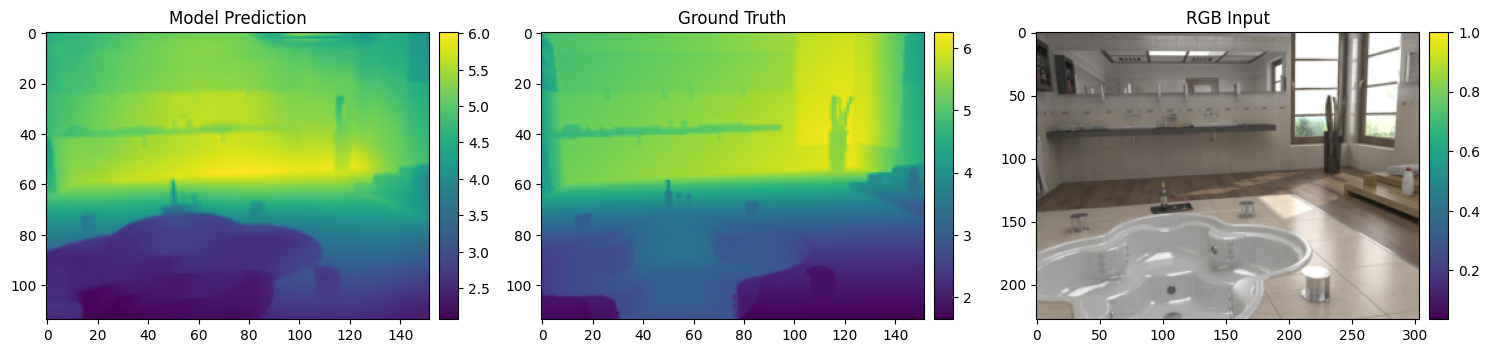

torch.Size([1, 114, 152])
torch.Size([1, 114, 152])
torch.Size([3, 228, 304])


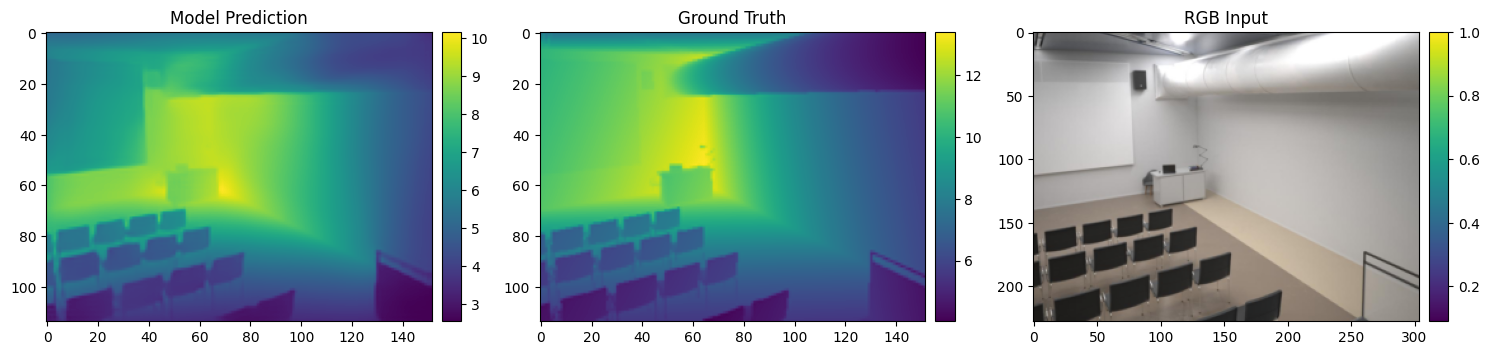

torch.Size([1, 114, 152])
torch.Size([1, 114, 152])
torch.Size([3, 228, 304])


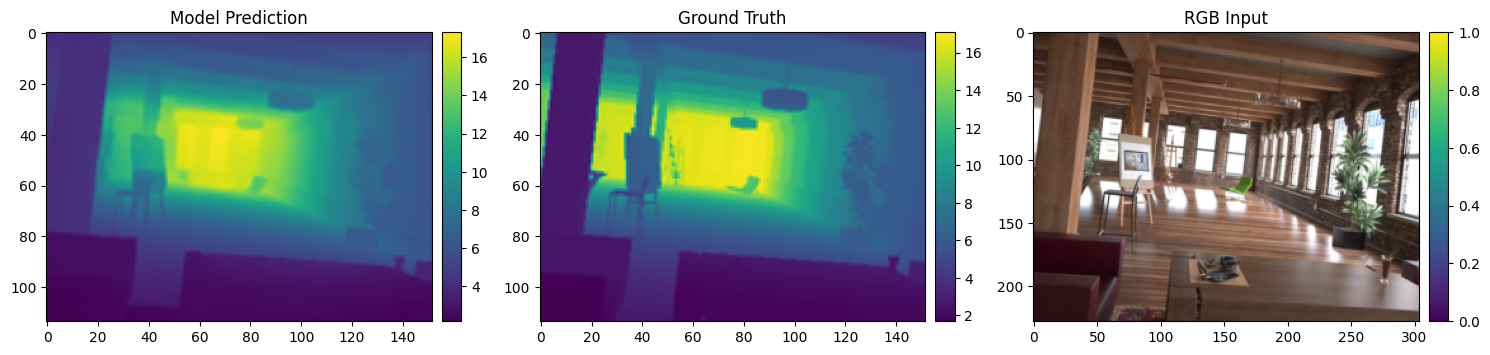

torch.Size([1, 114, 152])
torch.Size([1, 114, 152])
torch.Size([3, 228, 304])


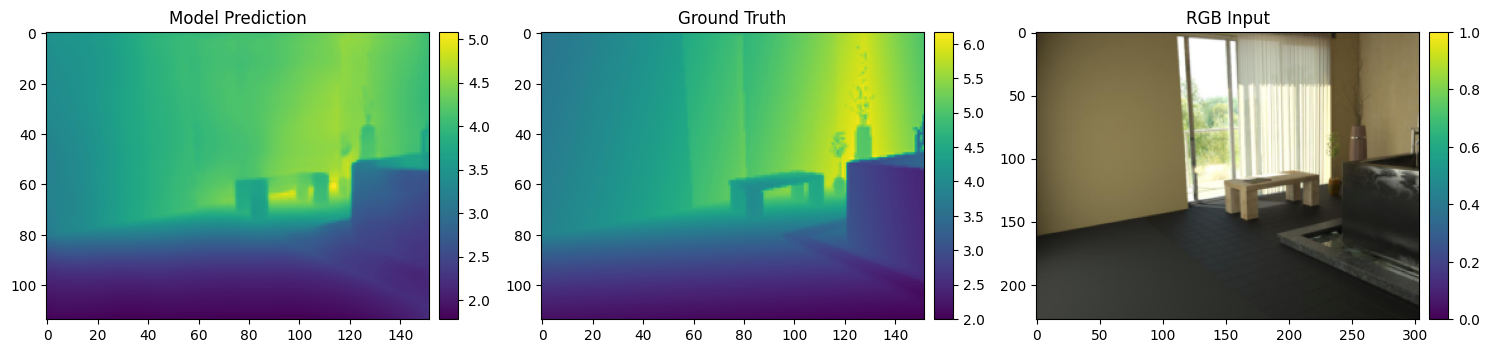

In [13]:
#plotname = "visual_plots_"+model_checkpoint_file[17:-14]
plotname = None
for i, tensors in enumerate(depth_results):
    outputs,depths,rgbs = tensors
    outputs = outputs[0,:,:,:].cpu()
    depths = depths[0,:,:,:].cpu()
    rgbs = rgbs[0,-3:,:,:].cpu()
    if(plotname != None):
        final_plotname = plotname + "_image_"+str(i)
    else: 
        final_plotname = None
    display_tensor_data_many(tensors=[outputs,depths,rgbs],remap=[None,None,denormalize], plot_name=final_plotname)
    #display_error_plots(depths, outputs)


## Plot for GrayScale Segmentation Masks

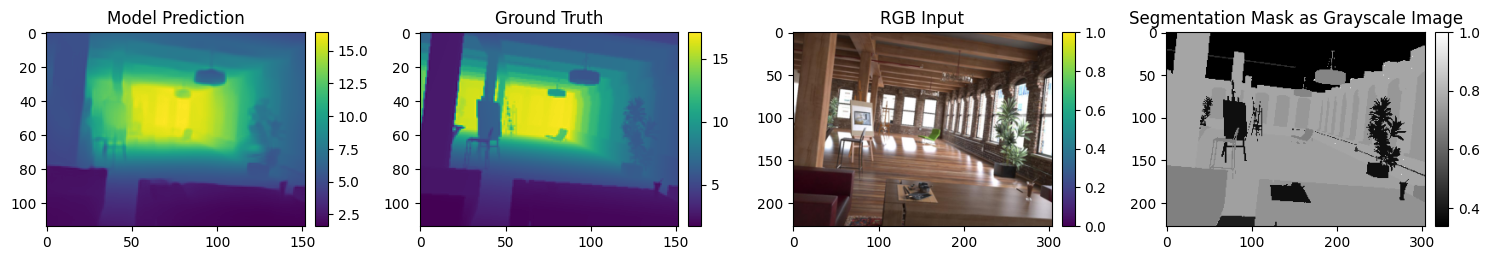

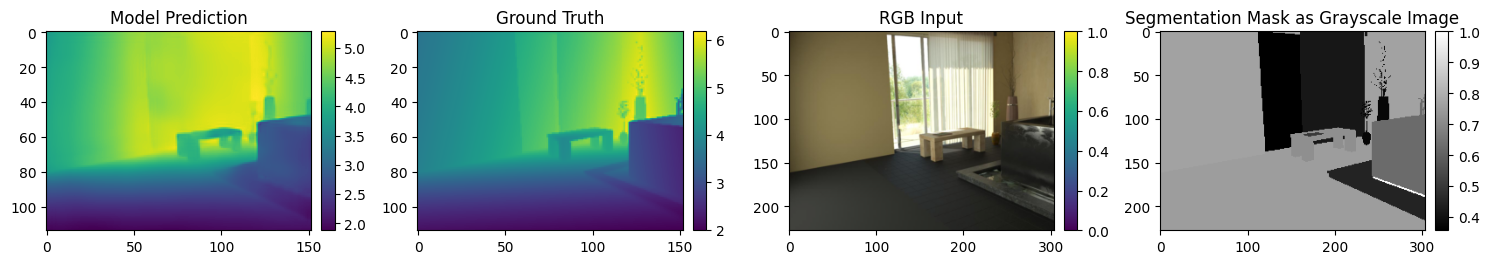

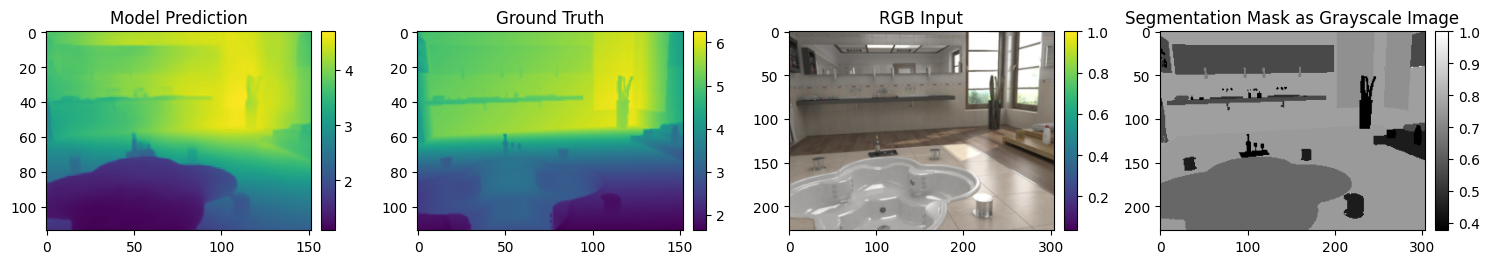

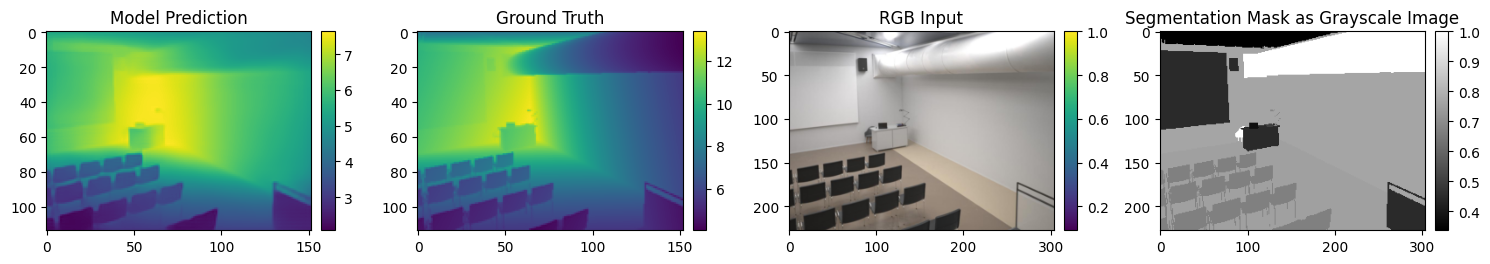

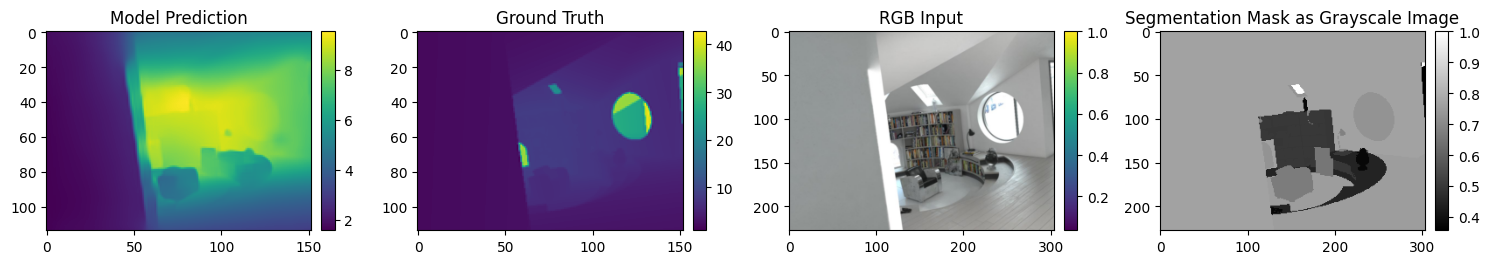

In [9]:
#plotname = "visual_plots_segmentation_"+model_checkpoint_file[17:-14]
plotname = None
for i, tensors in enumerate(depth_results):
    outputs,depths,rgbs = tensors
    outputs = outputs[0,:,:,:].cpu()
    depths = depths[0,:,:,:].cpu()
    segmentation = rgbs[0,0:1,:,:].cpu()
    rgbs = rgbs[0,-3:,:,:].cpu()
    if(plotname != None):
        final_plotname = plotname + "_image_"+str(i)
    display_tensor_data_many(tensors=[outputs,depths,rgbs, segmentation], titles = ["Model Prediction", "Ground Truth", "RGB Input", "Segmentation Mask as Grayscale Image"], remap=[None,None,denormalize, None], plot_name=final_plotname)
    #display_error_plots(depths, outputs)


### Loading outputs and printing them
This is not meaningfull since we are not able to get the same samples as while training/validating on cluster...
I will leave this commented for now

In [ ]:
# depth_outputs = torch.load(download_path+validation_tensor_path)

# print(depth_outputs.shape)

In [ ]:
# test_loader = getTestingData(1, validation_image_path_csv)

In [ ]:
# sample_batched = next(iter(test_loader))
# for i in range(depth_outputs.shape[0]):
#     curr_depth = depth_outputs[i,0,:,:,:].cpu()
#     # display_tensor_data(curr_depth.detach())
#     # display_tensor_data(sample_batched["depth"][0,:].detach())
#     # display_tensor_data(sample_batched["image"][0,:].detach(), denormalize)
#     # print("====")
#     display_tensor_data_many([curr_depth.detach(),sample_batched["depth"][0,:].detach(),sample_batched["image"][0,:].detach()],remap=[None,None,denormalize])

In [ ]:
# sample_batched = next(iter(test_loader))
# for i in range(depth_outputs.shape[0]):
#     curr_depth = depth_outputs[i,0,:,:,:].cpu()
#     print(i)
#     display_image_triplets(sample_batched["depth"][0,:].detach(), curr_depth.detach())
    

#### Plotting Losses


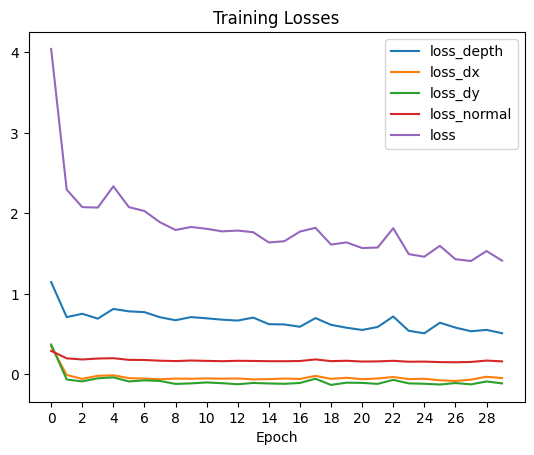

In [18]:
results_df = pd.read_csv(training_progress_data)

#plot_name = "training_loss_"+train_progress_file[7:-12]
plot_name = None
plot_training_progress(results_df,"Training Losses", plot_name)

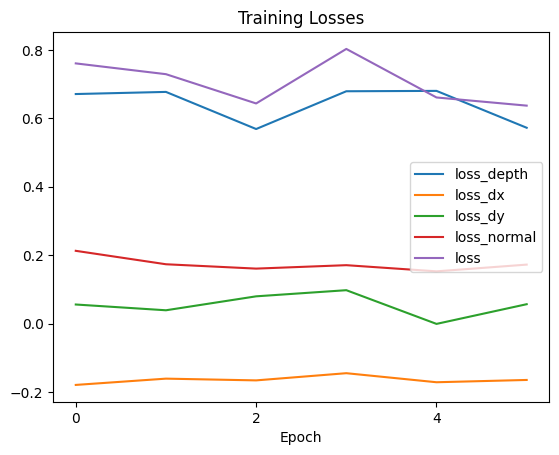

In [61]:
results_df = pd.read_csv(validation_progress)

#plot_name = "training_loss_"+train_progress_file[7:-12]
plot_name = None
plot_training_progress(results_df,"Training Losses", plot_name)

In [ ]:
resutls_csv_file_name2 = "train-results2.csv"
results_csv2 = download_path + "../outputs/results/" + resutls_csv_file_name2
results_df2 = pd.read_csv(results_csv2)
plot_results(results_df2,"Training Losses of second run")

### Testing the model (Expecting you ran above cells and already loaded the model)

In [10]:
import test
torch.cuda.empty_cache()


In [11]:
import warnings
testing_csv = "validation_data.csv"
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    print(model_checkpoint_file)
    print("working on file:",testing_csv)
    print(my_method)
    if my_method is Method.JOINTLEARNING:
        test_loader = getTestingData(3, testing_csv,segmentation_classes_csv_filename=selected_segmentation_classes)
        test.test_sample_joint(test_loader, model, 2e-04)
    else:
        test_loader = getTestingData(5, testing_csv,segmentation_classes_csv_filename=selected_segmentation_classes)
        test.test(test_loader, model, 2e-04)

checkpointapple-.05-31-2023-15-48-14-Method.JOINTLEARNING-final.pth.tar
working on file: validation_data.csv
Method.JOINTLEARNING
My Method in dataloader is:  Method.JOINTLEARNING
{'MSE': 66.54364979360211, 'RMSE': 8.157429116676536, 'ABS_REL': 0.5872102088874646, 'LG10': 0.19624628029847413, 'MAE': 2.816423972684346, 'DELTA1': 0.40411037027308133, 'DELTA2': 0.6542716284097982, 'DELTA3': 0.7892830248084965}
{'Precision_of_EdgeMap-0.25': 0.740687565928691, 'Recall_of_EdgeMap-0.25': 0.6676283648529628, 'F_Measure-0.25': 0.689686986175765, 'Relative_EdgeMap_Error-0.25': 0.3227759003639221, 'Precision_of_EdgeMap-0.5': 0.7357224539452483, 'Recall_of_EdgeMap-0.5': 0.4966600512282915, 'F_Measure-0.5': 0.5722094434849875, 'Relative_EdgeMap_Error-0.5': 0.29205769300460815, 'Precision_of_EdgeMap-1.0': 0.7592212981942165, 'Recall_of_EdgeMap-1.0': 0.3676863433320272, 'F_Measure-1.0': 0.4740843079920509, 'Relative_EdgeMap_Error-1.0': 0.21988630294799805, 'Precision_of_EdgeMap-1.25': 0.7785852399013